# Minimum Volume Ellipsoids を解くアルゴリズム

参考
* [Minimum Volume Ellipsoids](https://www.amazon.co.jp/-/en/Michael-J-Todd/dp/1611974372)
* [Derivative of ln (det X)](https://statisticaloddsandends.wordpress.com/2018/05/24/derivative-of-ln-det-x/)
* [ベクトルの内積とは？](https://risalc.info/src/inner-product.html#defR)
* [安易に逆行列を数値計算するのはやめよう](https://opqrstuvcut.github.io/blog/posts/%E5%AE%89%E6%98%93%E3%81%AB%E9%80%86%E8%A1%8C%E5%88%97%E3%82%92%E6%95%B0%E5%80%A4%E8%A8%88%E7%AE%97%E3%81%99%E3%82%8B%E3%81%AE%E3%81%AF%E3%82%84%E3%82%81%E3%82%88%E3%81%86/)
* [TFのrank-one Cholesky更新](https://www.tensorflow.org/probability/api_docs/python/tfp/math/cholesky_update)
* [Wikipedia (Cholesky decomposition)](https://en.wikipedia.org/wiki/Cholesky_decomposition)

表記
* 行列の内積（[ベクトルの内積とは？](https://risalc.info/src/inner-product.html#defR)参照）：$\langle A, B \rangle := \operatorname{Trace}(A^T B)$

今回は[前回](CVX_MVEE_algorithm.ipynb)の続きです。
次の主問題と双対問題を解くことを考えます。

$$
\text{ 主問題 }\;  
\begin{cases}
&\min_{H\in S^n} f(H) := -\ln \det (H)\\
&x_i^T H x_i \leq n
\end{cases}
$$

$$
\text{ 双対問題 }\; 
\begin{cases}
&\max_{u\in \mathbb{R}^m} g(u) := \ln \det (XUX^T) \\
& e^T u = 1, \\
& u \geq 0
\end{cases}
$$

この二つはどうやったら効率よく解けそうでしょうか？
とりあえず二つの勾配について見てみましょう：

**主問題**
* $\ln\det$の微分は次の結果が有名です（[Derivative of ln (det X)](https://statisticaloddsandends.wordpress.com/2018/05/24/derivative-of-ln-det-x/)）：$\nabla(-\ln\det)(H)=-H^{-1}$
* $\ln \det(H)$の二回方向微分（導出は教科書のAppendix A.4を参照してください）：$E_1$の方向に方向微分した後、$E_2$の方向に方向微分すると、次の$E_1$と$E_2$についての関数が得られます
    * $\nabla^2 \ln \det(H)[E_1, E_2]=\langle -(H^{-1}E_1 H^{-1}), E_2\rangle$

**双対問題**

* $w(u):=\nabla g(u) = (x_i^T H(u) x_i)^m_{i=1}$
* $(\nabla^2 g(u))_{i, j} = -(x_i^T H(u) x_j)^2, \; i,j=1, \dots, m$
    * ここで、$H(u):=(XUX^T)^{-1}$です

このことから、主問題でも双対問題でも二回微分を考えることはそう難しくないことがわかります。
しかし、$n$が特に大きいときは、$n\times n$の行列$H$の逆行列を各イテレーションで考える作業はコストが大きいですね。

この問題は、双対問題の1次微分を使った座標上昇法を考えれば回避できます。$H(u)$を計算する際に逆行列が必要になりますが、座標上昇法みたいに変数を一つ変えるだけであれば、逆行列は効率よく計算できます。

In [1]:
import numpy as np
import jax.numpy as jnp
import jax


def log_det(X):
    return -jnp.log(jnp.linalg.det(X))


def mat_prod(A, B):
    return jnp.trace(A.T @ B)


n = 2
L = jnp.array([[4., 0.], [2., 3.]])
H = L @ L.T
H_inv = jnp.linalg.inv(H)


# X = Hでの一回微分
jax_grad = jax.grad(log_det)(H)  # jaxによる勾配
analytical_grad = -H_inv  # 解析解
assert jax_grad.shape == H.shape

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## 座標上昇法を使ったアルゴリズム

表記
* $i$：座標上昇法で選択した座標
* $b\in [m]$：適当なインデックス

$u\in \mathbb{R}^m$を双対問題の実行可能解とします。つまり、$u$は非負かつ$e^Tu=1$、そして$g(u)=\ln\det(XUX^T)$は有限であり、$XUX^T$は正則であるとします。
この$u$を使って、

$$w:=w(u)=\nabla g(u) = (x_b^T H(u) x_b)^m_{b=1}$$

を持っているとしましょう。ここで、$H:=H(u):=(XUX^T)^{-1}$です。

さて、この$u$について

$$u_+:=(1-\tau)u + \tau e_i$$

で更新することを考えます。ここで$\tau\neq 1$であり、$e_i$は$i$軸に沿った単位ベクトルです。$u=e_i$を代入すると、これも双対問題の実行可能解であることがわかります。
これは次のように書き換えることも可能です：

$$\hat{u}:=u + \lambda e_i$$

ここで、$\lambda:=\tau / (1-\tau)$です。つまり、$u_+=(1-\tau)\hat{u}$になっています。
$-u_i \leq \lambda < \infty$である限り、$u_+$は非負かつ$e_i$と一致しないことがわかります。

このような更新を行うと、更新後の$XUX^T$に良い性質が生まれます。更新後の行列は

$$XU_+X^T=(1+\lambda)^{-1}(XUX^T + \lambda x_i x_i^T)$$

の形になります。この行列式と逆行列は次のように効率よく計算することができます。

---

$$\det(XU_+X^T)=(1+\lambda)^{-n}(1+\lambda w_i)\det (XUX^T)$$

また、$1+\lambda w_i$が正であれば、$XU_+X^T$は正則であり、
$$(XU_+X^T)^{-1}=(1+\lambda)\left(H-\frac{\lambda}{1+\lambda w_i}Hx_ix_i^TH\right)$$

---

これより、更新後の目的関数もきれいに書くことができます。

$$
g(u_+) - g(u)=-n \ln (1+\lambda) + \ln (1 + \lambda w_i)
$$

です。

この差分を最大化させるように$\lambda$を決定すると、最適な更新ステップがわかりそうですね。実際、
$$\lambda^*:= \frac{w_i-n}{(n-1)w_i}$$
でこの更新量は最大になり、$\lambda^*\geq -u_i$である限り、$(n-1)\ln\left(\frac{(n-1)w_i}{n(w_i-1)}\right)+\ln\left(\frac{w_i}{n}\right)$だけ増えます。
$\lambda^*\geq -u_i$が満たされないときは最適な$\lambda$は$-u_i$になります。

また、更新後の$w = (x_b^T H(u) x_b)^m_{b=1}$は

$$w_b(u_+)=(1+\lambda)\left(w_b - \frac{\lambda}{1+\lambda w_i}(\hat{x}^T x_b)^2\right)$$
が成立します。ここで、$\hat{x}:=Hx_i$としました。また、とくに

$$w_i(u_+)=(1+\lambda)\left(w_i - \frac{\lambda w_i^2}{1+\lambda w_i}\right)=\frac{(1+\lambda)w_i}{1+\lambda w_i}$$

が成立します。

### インデックス$i$の選び方

教科書では選び方のモチベーションが３つ説明されていますが、ここでは簡単なやつを紹介します（詳細はp.28参照）。

目的関数$g(u)$のテイラー展開を考えると、

$$
g(u+\Delta u)\approx \tilde{g}(u+\Delta u):= g(u)+w^T \Delta u
$$

であるため、$e_i$の方向としては$w_i$が一番大きいインデックスを選べば良いことがわかります。これをするのが**Frank-Wolfeアルゴリズム**です。

また、Frank-Wolfeに追加して、最も悪い$w_j$から逃げるように更新することも考えられます。これはAtwoodによって提案されているっぽいので、こちらはWolfe-Atwoodアルゴリズムと呼ばれています。

### Frank-Wolfeアルゴリズム

以上をまとめて、Frank-Wolfeアルゴリズムを見てみましょう。
Frank-Wolfeアルゴリズムの一番大変な部分は$w=(x_i^T H x_i)_i^m$であり、この計算の効率化がアルゴリズムの高速化に繋がります。
上で説明したように、更新後の$w$は
$$w_b(u_+)=(1+\lambda)\left(w_b - \frac{\lambda}{1+\lambda w_i}(\hat{x}_i^T x_b)^2\right)$$
であり、$\hat{x}_i:=Hx_i$が効率的に計算できればよいわけですね。

ここで、$XUX^T$のscaled Cholesky分解を
$$XUX^T=LL^T$$
とします。ここで$L$は下三角行列です。

このとき、$\hat{x}_i=L^{-T}L^{-1}x_i$の形になっています。
実は、単純に$L^{-T}L^{-1}$を逆行列で計算すると計算量は$O(n^3)$ですが、この式を変形して連立一次方程式を解くと計算量は$O(n^2)$でいけます。
まず、$z_i=L^{-1}x_i$を考えましょう。変形すると$Lz_i = x_i$であり、これを解いて$z_i$を求めます。
次に$L^T \hat{x}_i = z_i$を解けば$\hat{x}_i$が求まります。
（参考：[安易に逆行列を数値計算するのはやめよう](https://opqrstuvcut.github.io/blog/posts/%E5%AE%89%E6%98%93%E3%81%AB%E9%80%86%E8%A1%8C%E5%88%97%E3%82%92%E6%95%B0%E5%80%A4%E8%A8%88%E7%AE%97%E3%81%99%E3%82%8B%E3%81%AE%E3%81%AF%E3%82%84%E3%82%81%E3%82%88%E3%81%86/)）

つまりCholesky分解があれば$O(n^2)$で$w$が求まるので、$L$も$L_+$に更新しましょう。
ここで、
$$XU_+X^T=\frac{1}{(1+\lambda)} LL^T + \frac{\lambda}{1 + \lambda} x_i x_i^T$$
であることに注意しましょう。
つまり、$\bar{L}:= L / \sqrt{1 + \lambda}$と$\bar{x}:=\sqrt{\frac{\lambda}{1 + \lambda}}x_i$として、
$$XU_+X^T=\bar{L}\bar{L}^T + \bar{x}_i \bar{x}_i^T$$
になります。
このようにCholesky分解をrank-oneで更新する場合、Cholesky分解は$O(n^2)$でできることが知られています（参考：[TFのrank-one Cholesky更新](https://www.tensorflow.org/probability/api_docs/python/tfp/math/cholesky_update)）。

[Wikipedia (Cholesky decomposition)](https://en.wikipedia.org/wiki/Cholesky_decomposition)を参考に、rank-one Cholesky updateを実装してみましょう。
また、$\lambda$の符号が負の場合にも対応できるようにしておきます。

In [2]:
import jax.numpy as jnp
import numpy as np
import jax


@jax.jit
def cholupdate(L, x, lam):
    sign = jnp.sign(lam)
    L = L / jnp.sqrt(1 + lam)
    x = x * jnp.sqrt(sign * lam / (1 + lam))

    n = jnp.size(x)
    for k in range(n):
        r = jnp.sqrt(L[k,k]**2 + sign * x[k]**2)
        c = r / L[k,k]
        s = x[k] / L[k,k]
        L = L.at[k,k].set(r)
        if k < n:
            L = L.at[k+1:n, k].set((L[k+1:n, k] + sign * s*x[k+1:n]) / c)
            x = x.at[k+1:n].set(c*x[k+1:n] - s*L[k+1:n, k])
    return L


# テスト
n = 3
m = 200
X = jnp.array(np.random.randn(n, m))
XUX = X @ jnp.diag(jnp.ones(m) / m) @ X.T
L = jnp.linalg.cholesky(XUX)

i = 3
x = X[:, i]
lam = 0.1
L_updated = cholupdate(L, x, lam)
XUX_updated = L @ L.T / (1 + lam) + x[:, None] @ x[None, :] * lam / (1 + lam)
L_true = jnp.linalg.cholesky(XUX_updated)
np.testing.assert_allclose(L_updated, L_true, atol=1e-5)

lam_neg = -0.1
L_updated = cholupdate(L, x, lam_neg)
XUX_updated = L @ L.T / (1 + lam_neg) + x[:, None] @ x[None, :] * lam_neg / (1 + lam_neg)
L_true = jnp.linalg.cholesky(XUX_updated)
np.testing.assert_allclose(L_updated, L_true, atol=1e-5)

以上の内容をまとめてみましょう：

**Frank-Wolfe アルゴリズム**

0. 初期化です。
   1. 双対問題の実行可能解$u$を一つ選択します。$u=e/m$とします。（他にも選び方は色々あります。教科書p.30参照。）
   2. $\varepsilon > 0$を選択します。
   3. 初期のCholesky 分解$XUX^T=LL^T$を計算します。
   4. 初期の$w=(x_b^T H x_b)_b^m$を計算します。
1. $\varepsilon_+ := \max_b (w_b - n) / n$を計算し、最大値を与える$b$を$i$とします。計算量は$O(m)$です。
2. もし$\varepsilon_+ \leq \varepsilon$であれば、$u$は$\varepsilon$最適な解なので終了します。（[CVX_minimum_volume_ellipsoids.ipynb](CVX_minimum_volume_ellipsoids.ipynb)を参考にしてください。）
3. $\varepsilon_+ > \varepsilon$ならば$\lambda^*:= (w_i-n) / ((n-1)w_i)$を計算し、$u \leftarrow (1+\lambda^*)^{-1}(u + \lambda^* e_i)$で更新します。
6. $\bar{L}:= L / \sqrt{1 + \lambda}$と$\bar{x}:=\sqrt{\frac{\lambda}{1 + \lambda}}x_i$として、$L\leftarrow\operatorname{cholupdate}(\bar{L}, \bar{x})$で$L$を更新します。
7. 連立一次方程式$L z_i = x_i$を解いて$z_i$を計算します。
8. 連立一次方程式$L^T \hat{x}_i = z_i$を解いて$\hat{x}_i$を計算します。
9. $w_b=(1+\lambda)\left(w_b - \frac{\lambda}{1+\lambda w_i}(\hat{x}_i^T x_b)^2\right)$によって$w$を更新します。
10. ステップ１に戻ります。

コレスキー分解を使ったやつはあまり安定しなかったので、先に逆行列を丁寧に計算する方を実装してみます。

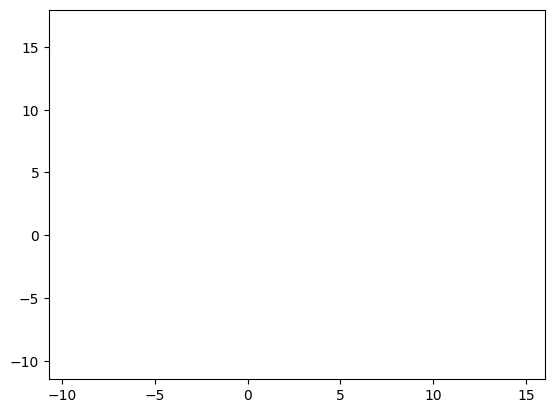

In [3]:
import numpy as np
import jax.numpy as jnp
import jax

m = 100
prngkey = jax.random.PRNGKey(5)
Y = jax.random.normal(prngkey, (2, m)) * 3
Y = Y + jax.random.uniform(prngkey, (2, m)) * 5
Y = jnp.array(Y)  # 元データ
X = jnp.vstack((Y, jnp.array([1,] * m)))  # 中心を計算する用
n = 2 + 1
assert X.shape == (n, m)

# Frank-Wolfe アルゴリズム
vmap_dot = jax.vmap(jnp.dot)

# >>>> 初期化 >>>>
# 0.1
u = jnp.ones(m) / m

# 0.2
epsilon = 0.01  # 精度

# 0.4
XUX = X @ jnp.diag(u) @ X.T
H = jnp.linalg.inv(XUX)
vmap_xHx = jax.vmap(lambda x: x @ H @ x)
w = vmap_xHx(X.T)
assert w.shape == (m,)

# <<<< 初期化 <<<<

@jax.jit
def one_step_exact_FW(u, L, w):
    # １ステップFrank-Wolfeアルゴリズム

    # 1. iの計算
    i = w.argmax()
    cur_epsilon = ((w - n) / n)[i]
    w_i = w[i]
    u_i = u[i]

    # 3. 更新幅の計算とuの更新
    lam = (w_i - n) / ((n - 1) * w_i)
    lam = jnp.maximum(lam, -u_i)
    u = u.at[i].set(u_i + lam)
    u = u / (1 + lam)

    # 0.3：コレスキー分解
    XUX = X @ jnp.diag(u) @ X.T
    H = jnp.linalg.inv(XUX)
    vmap_xHx = jax.vmap(lambda x: x @ H @ x)
    w_updated = vmap_xHx(X.T)
    assert w.shape == (m,)
    return cur_epsilon, u, L, w_updated


# 描画

import matplotlib.pyplot as plt
from celluloid import Camera

def plot_ellipsoid(u):
    # データの描画
    x, y = Y
    plt.scatter(x, y)

    # 楕円の描画
    y_ = Y @ u
    theta = np.linspace(0, 2 * np.pi, 100)
    x = np.cos(theta)
    y = np.sin(theta)
    XUX = X @ jnp.diag(u) @ X.T
    H = jnp.linalg.inv(XUX)
    H = H[:-1, :-1]
    L_plot = np.linalg.cholesky(H)
    L_plot_T = np.linalg.inv(L_plot).T
    x2, y2 = [], []
    for _x, _y in zip(x, y):
        v = y_ + np.sqrt(n) * np.dot(L_plot_T, np.array([_x, _y]))
        x2.append(v[0])
        y2.append(v[1])
    plt.scatter(x2, y2, s=30)


fig = plt.figure()
camera = Camera(fig)

cur_epsilon = jnp.inf
count = 0
while True:
    cur_epsilon, new_u, new_L, new_w = one_step_exact_FW(u, L, w)
    if cur_epsilon <= epsilon:
        break
    u, L, w = new_u, new_L, new_w
    count += 1
    if count < 10:
        plot_ellipsoid(u)
        camera.snap()


animation = camera.animate()
animation.save("./figs/MVEE_exact.gif")

![fig](figs/MVEE_exact.gif)

コレスキー分解を使ったやつもやってみます。

In [4]:
import numpy as np
import jax.numpy as jnp
import jax

m = 10000
prngkey = jax.random.PRNGKey(10)
Y = jax.random.normal(prngkey, (2, m)) * 3
Y = Y + jax.random.uniform(prngkey, (2, m)) * 5
Y = jnp.array(Y)  # 元データ
X = jnp.vstack((Y, jnp.array([1,] * m)))  # 中心を計算する用
n = 2 + 1
assert X.shape == (n, m)

# Frank-Wolfe アルゴリズム
vmap_dot = jax.vmap(jnp.dot)

# >>>> 初期化 >>>>
# 0.1
u = jnp.ones(m) / m

# 0.2
epsilon = 0.01  # 精度

# 0.3：コレスキー分解
XUX = X @ jnp.diag(u) @ X.T
L = jnp.linalg.cholesky(XUX)
np.testing.assert_allclose(XUX, L @ L.T, atol=1e-5)

# 0.4
H = jnp.linalg.inv(XUX)
vmap_xHx = jax.vmap(lambda x: x @ H @ x)
w = vmap_xHx(X.T)
assert w.shape == (m,)

# <<<< 初期化 <<<<

@jax.jit
def one_step_FW(u, L, w):
    # １ステップFrank-Wolfeアルゴリズム
    # 1. iの計算
    i = w.argmax()
    cur_epsilon = ((w - n) / n)[i]
    w_i = w[i]
    x_i = X[:, i]
    u_i = u[i]

    # 3. 更新幅の計算とuの更新
    lam = (w_i - n) / ((n - 1) * w_i)
    lam = jnp.maximum(lam, -u_i)
    u = u.at[i].set(u_i + lam)
    u = u / (1 + lam)

    # 5. wの更新
    z_i = jnp.linalg.solve(L, x_i)
    H_x_i = jnp.linalg.solve(L.T, z_i)
    xx2 = (H_x_i @ X) ** 2
    w_updated = (1 + lam) * (w - (lam / (1 + lam * w_i) * xx2))

    # 4. 下三角行列の更新
    L = cholupdate(L, x_i, lam)

    return cur_epsilon, u, L, w_updated

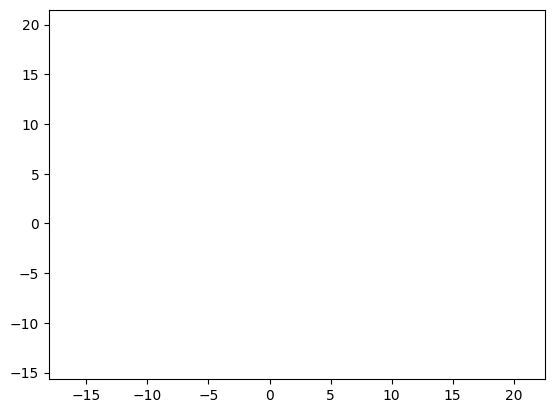

In [5]:
import matplotlib.pyplot as plt
from IPython.display import HTML
from celluloid import Camera


def plot_ellipsoid(u):
    # データの描画
    x, y = Y
    plt.scatter(x, y)

    # 楕円の描画
    y_ = Y @ u
    theta = np.linspace(0, 2 * np.pi, 100)
    x = np.cos(theta)
    y = np.sin(theta)
    XUX = X @ jnp.diag(u) @ X.T
    H = jnp.linalg.inv(XUX)
    H = H[:-1, :-1]
    L_plot = np.linalg.cholesky(H)
    L_plot_T = np.linalg.inv(L_plot).T
    x2, y2 = [], []
    for _x, _y in zip(x, y):
        v = y_ + np.sqrt(n) * np.dot(L_plot_T, np.array([_x, _y]))
        x2.append(v[0])
        y2.append(v[1])
    plt.scatter(x2, y2, s=30)


fig = plt.figure()
camera = Camera(fig)

cur_epsilon = jnp.inf
count = 0
while True:
    cur_epsilon, new_u, new_L, new_w = one_step_FW(u, L, w)
    if cur_epsilon <= epsilon:
        break
    u, L, w = new_u, new_L, new_w
    count += 1
    if count < 10:
        plot_ellipsoid(u)
        camera.snap()


animation = camera.animate()
animation.save("./figs/MVEE.gif")

![figs](figs/MVEE.gif)

## Core-setの獲得

主問題と双対問題を改めて確認しましょう。

---

**主問題と双対問題の直感**

$$
\text{ 主問題 }\;  
\begin{cases}
&\min_{H\in S^n} f(H) := -\ln \det (H) \quad &&\text{ （楕円の面積を最小にする） }\\
&x_i^T H x_i \leq n \quad &&\text {（楕円はデータを全て含む）}
\end{cases}
$$

主問題の解釈は簡単ですね。双対問題はどうでしょうか。

$$
\text{ 双対問題 }\; 
\begin{cases}
&\max_{u\in \mathbb{R}^m} g(u) := \ln \det (XUX^T) \\
& e^T u = 1\\
& u \geq 0
\end{cases}
$$

* TODO: こっからまじで雰囲気で書いています。線形代数の回を作ったら書き直します。一応[Derivative of ln (det X)](https://statisticaloddsandends.wordpress.com/2018/05/24/derivative-of-ln-det-x/)に基づいた直感を書いています。
    * $XUX^T$は$\sum_i^n u_i x_i x_i^T$であるから、$\det (XUX^T)$は「$U$によって選択されたデータが作る平行六面体の体積」と解釈することができます
    * また、$H(u)=(XUX^T)^{-1}$によって作られる楕円は、一番大きい平行六面体を囲むように作られた楕円と解釈できます。

つまり、$u_i=0$のデータ$x_i$は最小楕円を作る上では重要ではないデータであり、$\{x_i: u_i > 0\}$であるデータだけでも同じ最小楕円が得られます。このような$\{x_i: u_i > 0\}$は**core-set**と呼ばれます。

---

これを踏まえて、$\varepsilon$-core setを導入します。
まず、[CVX_minimum_volume_ellipsoids.ipynb](CVX_minimum_volume_ellipsoids.ipynb)でやった近似最適解の性質を思い出しましょう。

* 実行可能解$u$は次を満たすとき$\varepsilon$-主実行可能であると言う。
    * $H(u):=(XU^TX)^{-1}$が $x_i^T H(u)x_i \leq (1 + \varepsilon) n, \quad i=1,\dots, m$ を満たす。

よって、$u$が$\varepsilon$-主実行可能解であるならば、$H(u)$によって作られる楕円は最適解よりも大きくなり、かつ全てのデータを含みます。
また、書き換えると$\mathcal{E}([1+\varepsilon]^{-1}H(u))$が$X$を含むこともわかります。
$H(u)$を$[1+\varepsilon]^{-1}$でスケールしているので、その体積は$[1+\varepsilon]^{-n}$倍されます。

このような$u$について$S=\{x_i; u_i >0\}$とすると、$g(u)$は$S$を含む最小楕円の近似解でもあるわけです。
$\varepsilon$-主実行可能解は$n\ln(1+\varepsilon)$-以内最適であることを思い出すと、$S$が生成する楕円の最小楕円との違いは$[1+\varepsilon]^{-n}$のオーダー程度になります（多分）。
このような$S$は$\varepsilon$-core-setと呼ばれます。


**データの削減**

TODO: 詳細書く。

実はアルゴリズムが$\varepsilon$-主実行可能解（もしくは$\varepsilon$-最適解）で停止すると、FWアルゴリズムは$4n(\ln \ln n+4) + 28 n / \varepsilon$のサイズのコアセットを出力します。
（これは特殊な初期条件についてしか成り立たないことに注意しましょう。詳しくは教科書p.43）

詳細は省略しますが、$\delta:=\delta(u)=(w_i(u) - n) / n > 0$とすると、

$$
w_i(u) < n\left(1 + \frac{\delta n}{2} - \sqrt{\delta n - \delta + \frac{\delta^2 n^2}{4}}\right)
$$
を満たす$x_i$は無視することでcore-setを作ることができます（教科書p.44）。

このデータの削減をWolfe-Atwoodのアルゴリズム（教科書p.29）と合体させて確認してみましょう。

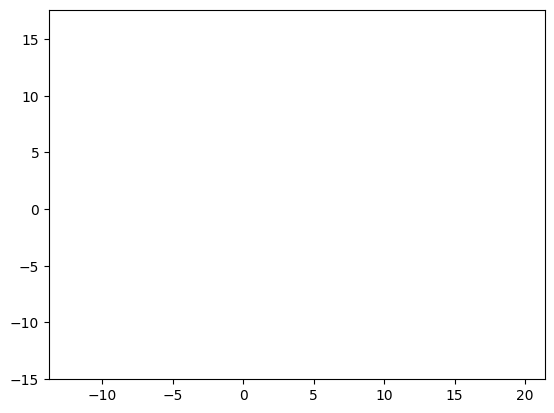

In [10]:
import numpy as np
import jax.numpy as jnp
import jax

m = 1000
prngkey = jax.random.PRNGKey(10)
Y = jax.random.normal(prngkey, (2, m)) * 3
Y = Y + jax.random.uniform(prngkey, (2, m)) * 5
Y = jnp.array(Y)  # 元データ
X = jnp.vstack((Y, jnp.array([1,] * m)))  # 中心を計算する用
n = 2 + 1
assert X.shape == (n, m)

# Frank-Wolfe アルゴリズム
vmap_dot = jax.vmap(jnp.dot)

# >>>> 初期化 >>>>
# 0.1
u = jnp.ones(m) / m

# 0.2
epsilon = 0.01  # 精度

# 0.3：コレスキー分解
XUX = X @ jnp.diag(u) @ X.T
L = jnp.linalg.cholesky(XUX)
np.testing.assert_allclose(XUX, L @ L.T, atol=1e-5)

# 0.4
H = jnp.linalg.inv(XUX)
vmap_xHx = jax.vmap(lambda x: x @ H @ x)
w = vmap_xHx(X.T)
assert w.shape == (m,)

# <<<< 初期化 <<<<

# @jax.jit
def one_step_WA_pos(u, L, w):
    # １ステップWolfe-Atwoodアルゴリズム。最大化方向の更新
    # 1. iの計算
    i = w.argmax()
    cur_epsilon = ((w - n) / n)[i]
    w_i = w[i]
    x_i = X[:, i]
    u_i = u[i]

    # 3. 更新幅の計算とuの更新
    lam = (w_i - n) / ((n - 1) * w_i)
    lam = jnp.maximum(lam, -u_i)
    u = u.at[i].set(u_i + lam)
    u = u / (1 + lam)

    # 5. wの更新
    z_i = jnp.linalg.solve(L, x_i)
    H_x_i = jnp.linalg.solve(L.T, z_i)
    xx2 = (H_x_i @ X) ** 2
    w_updated = (1 + lam) * (w - (lam / (1 + lam * w_i) * xx2))

    # 4. 下三角行列の更新
    L = cholupdate(L, x_i, lam)

    return cur_epsilon, u, L, w_updated


# @jax.jit
def one_step_WA_neg(u, L, w):
    # １ステップWolfe-Atwoodアルゴリズム。最悪値の除去方向の更新
    # 1. iの計算
    w_ignore_u0 = w + (u == 0) * jnp.inf
    i = w_ignore_u0.argmin()
    cur_epsilon = ((n - w) / n)[i]
    w_i = w[i]
    x_i = X[:, i]
    u_i = u[i]

    # 3. 更新幅の計算とuの更新
    lam = (w_i - n) / ((n - 1) * w_i)
    lam = jnp.maximum(lam, -u_i)
    u = u.at[i].set(u_i + lam)
    u = u / (1 + lam)

    # 5. wの更新
    z_i = jnp.linalg.solve(L, x_i)
    H_x_i = jnp.linalg.solve(L.T, z_i)
    xx2 = (H_x_i @ X) ** 2
    w_updated = (1 + lam) * (w - (lam / (1 + lam * w_i) * xx2))

    # 4. 下三角行列の更新
    L = cholupdate(L, x_i, lam)

    return cur_epsilon, u, L, w_updated



import matplotlib.pyplot as plt
from IPython.display import HTML
from celluloid import Camera


def plot_ellipsoid(cur_epsilon, w, u):
    # データの描画
    x, y = Y
    p1 = plt.scatter(x, y, s=3, color="lightblue")

    delta = cur_epsilon
    thresh = ((delta ** 2) * (n ** 2)) / 4
    thresh = 1 + delta * n / 2 - jnp.sqrt(delta * n - delta + thresh)
    thresh = n * thresh
    essential_data = w >= thresh

    # Core-setの描画
    x, y = Y[:, essential_data]
    num_coreset = essential_data.sum()
    p2 = plt.scatter(x, y, s=30, color="red")

    # 楕円の描画
    y_ = Y @ u
    theta = np.linspace(0, 2 * np.pi, 100)
    x = np.cos(theta)
    y = np.sin(theta)
    XUX = X @ jnp.diag(u) @ X.T
    H = jnp.linalg.inv(XUX)
    H = H[:-1, :-1]
    L_plot = np.linalg.cholesky(H)
    L_plot_T = np.linalg.inv(L_plot).T
    x2, y2 = [], []
    for _x, _y in zip(x, y):
        v = y_ + np.sqrt(n) * np.dot(L_plot_T, np.array([_x, _y]))
        x2.append(v[0])
        y2.append(v[1])
    p3 = plt.scatter(x2, y2, s=30, color="green")

    plt.legend([p1, p2, p3], [f"Dataset: size={m}", f"Core set: size={num_coreset}", "Minimum Volume Ellipsoid"])


fig = plt.figure()
camera = Camera(fig)

i = w.argmax()
j = w.argmin()
cur_epsilon_pos = ((w - n) / n)[i]
cur_epsilon_neg = ((n - w) / n)[i]
count = 0
while True:
    if count < 30:
        plot_ellipsoid(cur_epsilon_pos, w, u)
        camera.snap()

    cur_epsilon_pos, u, L, w = one_step_WA_pos(u, L, w)
    cur_epsilon_neg, u, L, w = one_step_WA_neg(u, L, w)
    if max(cur_epsilon_pos, cur_epsilon_neg) <= epsilon:
        break
    count += 1

animation = camera.animate()
animation.save("./figs/MVEE-coreset.gif")

![fig](figs/MVEE-coreset.gif)